## Protein Flow Cytometry Data
**PAGE 625.** A graph consists of a set of vertices (nodes), along with a set of edges joining some pairs of the vertices. In graphical models, each vertex represents a random variable, and the graph gives a visual way of understanding the joint distribution of the entire set of random variables. They can be useful for either unsupervised or supervised learning. In an *undirected graph*, the edges have no directional arrows.  We restrict our discussion to undirected graphical models, also known as *Markov random fields* or *Markov networks*. In these graphs, the absense of an edge between two vertices has a special meaning: the corresponding random variables are conditionally independent, give the other variables.

Figure 17.1 shows an example of a graphical model for a flow-cytometry dataset with *p*=11 proteins measured on *N* = 7466 cells, from Sachs et al. (2005). Each vertex in the graph corresponds to the real-valued expression level of a protein. The network structure was estimated assuming a multivariate Gaussian distribution, using the graphical lasso procedure discussed leter in this chapter.


**DATA.** 7466 cells, one per row. 11 proteins, one per column.

Protein names are:

|   |     |   |     |   |     |   |     |
|---|-----|---|-----|---|-----|---|-----|
|1  |Raf  |2  |Mek  |3  |Plcg |4  |PIP2 |
|5  |PIP3 |6  |Erk  |7  |Akt  |8  |PKA  |
|9  |PKC  |10 |P38  |11 |Jnk  |

**WIKI.** Flow cytometry is a technique used to detect and measure physical and chemical characteristics of a population of cells or particles. A sample containing cells or particles is suspended in a fluid and injected into the flow cytometer instrument. The sample is focused to ideally flow one cell at a time through a laser beam and the light scattered is characteristic to the cells and their components. Cells are often labeled with fluorescent markers so that light is first absorbed and then emitted in a band of wavelengths. Tens of thousands of cells can be quickly examined and the data gathered are processed by a computer.

**YOUTUBE.** Good introduction video can be found here https://www.youtube.com/watch?v=W1BFeiDwqnk.

In [1]:
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

## Load and Prepare Data

In [2]:
X = np.loadtxt('../data/protein.data')
protein_names = [
    'Raf', 'Mek', 'Plcg', 'PIP2', 'PIP3',
    'Erk', 'Akt', 'PKA', 'PKC', 'P38', 'Jnk']
p = len(protein_names)

## Graphical Lasso
**PAGE 631.** Given some realizations of $X$, we would like to estimate the parameters of an undirected graph that approximates their joint distribution. Suppose first that the graph is complete (full connected). We assume that we have $N$ multivariate normal realizations $x_i, i=1,...,N$ with population mean $\mu$ and covariance $\mathbf{\Sigma}$. Let
$$\mathbf{S} = \frac{1}{N}\sum_{i=1}^{N}(x_i - \bar{x})(x_i - \bar{x})^T$$
be the empirical covariance matrix, with $\bar{x}$ the sample mean vector. Ignoring constants, the log-likelihood of the data can be written as
$$\ell(\mathbf{\Theta}) = \text{log }\text{det}\mathbf{\Theta} - \text{trace}(\mathbf{S}\mathbf{\Theta}).$$
In (17.11) we have partially maximized with respect to the mean parameter $\mu$. The quantity $-\ell(\mathbf{\Theta})$ is convex function of $\mathbf{\Theta}$. It is easy to show that the maximum likelihood estimate of $\mathbf{\Sigma}$ is simply $\mathbf{S}$.

Now to make the graph more useful (espacially in high-dimensional settings) let's assume that some of the edges are missing; for example, the edge PIP3 and Erk is one of several missing in Figure 17.1. As we have seen, for the Gaussian distribution this implies that the corresponding entries of $\mathbf{\Theta}=\mathbf{\Sigma}^{-1}$ are zero. Hence we now would like to maximize (17.11) under the constraints that some pre-defined subset of the parameters are zero.

**PAGE 635.** We can take a more systematic approach with the lasso penalty, following the development of the previous section. Consider maximizing the penalized log-likelihood
$$\text{log }\text{det}\mathbf{\Theta} - \text{trace}(\mathbf{S}\mathbf{\Theta})-\lambda ||\mathbf{\Theta}||_1,$$
where $||\mathbf{\Theta}||_1$ is the $L_1$ norm - the sum of the absolute values of the elements of $\mathbf{\Sigma^{-1}}$, and we have ignored constants. The negative of this penalized likelihood is a convex function of $\mathbf{\Theta}$.

**NOTE.** *sklearn.covariance* module has an implementation *GraphicalLasso*, but I have failed to exactly reproduce the results from the book. So, let's use great CVXPY package to optimize the model.

In [3]:
# the empirical covariance matrix
S = np.cov(X, rowvar=False)/1000
lambdas = [36, 27, 7]
theta_estimates = []

# PAGE 637. Figure 17.1 shows the result of applying the graphical lasso to the
#           flow-cytometry dataset. Here the lasso penalty λ was set at 14. In
#           practice it is informative to examine the different sets of graphs
#           that are obtained as λ is varied. Figure 17.6. shows four different
#           solutions. The graph becomes more sparse as the penalty parameter
#           is increased.
for lam in lambdas:
    # theta should be symmetric positive-definite
    theta = cp.Variable(shape=(p, p), PSD=True)
    # PAGE 636. An alternative formulation of the problem (17.21) can be posed,
    #           where we don't penalize the diagonal of theta.
    l1_penalty = sum([cp.abs(theta[i, j])
                      for i in range(p)
                      for j in range(p) if i != j])
    objective = cp.Maximize(
        cp.log_det(theta) - cp.trace(theta@S) - lam*l1_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver=cp.CVXOPT)
    if problem.status != cp.OPTIMAL:
        raise Exception('CVXPY Error')
    theta_estimates.append(theta.value)

lambdas.append(0)
theta_estimates.append(np.linalg.inv(S))

## Plotting

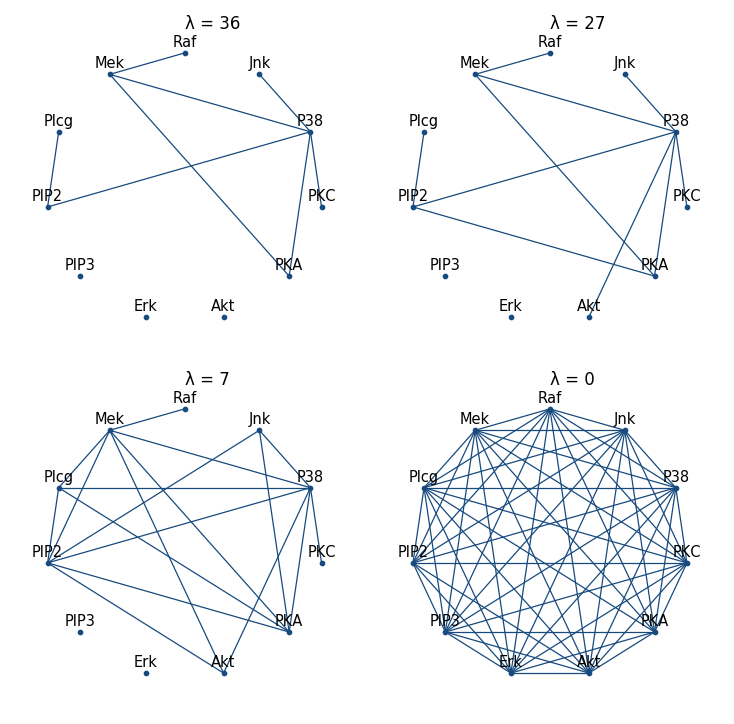

In [4]:
# PAGE 637. FIGURE 17.5. Four different graphical-lasso solutions for the
#           flow-cytometry data.
tmp = {name: name for name in protein_names}
fig, axarr = plt.subplots(2, 2, figsize=(6, 6), dpi=150)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

angles = np.linspace(0, 1, p + 1)[:-1] * 2 * np.pi + np.pi/2
for plot_idx in range(4):
    cons = np.argwhere(np.abs(theta_estimates[plot_idx]) > 0.00001)
    G, node_pos = nx.Graph(), {}
    for i, node in enumerate(protein_names):
        G.add_node(node)
        node_pos[node] = np.array([np.cos(angles[i]), np.sin(angles[i])])
    for i in range(cons.shape[0]):
        G.add_edge(protein_names[cons[i, 0]], protein_names[cons[i, 1]])
    ax = axarr[plot_idx//2, plot_idx % 2]
    nx.draw(G, node_pos, node_size=3, with_labels=False, ax=ax,
            edge_color='#174A7E', width=0.6, node_color='#174A7E')
    description = nx.draw_networkx_labels(G, node_pos, labels=tmp, ax=ax)
    for (i, (node, t)) in enumerate(description.items()):
        t.set_position((np.cos(angles[i]), np.sin(angles[i])+0.08))
        t.set_fontsize(7)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.text(0, 1.18, f'λ = {lambdas[plot_idx]}', fontsize=8)